<a href="https://colab.research.google.com/github/WeinanZhi/-CS539-PlantSeedPrediction/blob/master/Segment_Res18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit
import torch
import tensorflow as tf
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
path ="/content/drive/My Drive/课程作业/MachineLearning/MLproject/ProcessedDataByLei"
seg_X = torch.load(path+'/seg_train_X.pt')
seg_Y = np.loadtxt(path+'/seg_train_Y.txt').astype(np.int64)
seg_Y = torch.from_numpy(seg_Y)

print(seg_X.size())
print(seg_Y.size())

torch.Size([3251, 3, 224, 224])
torch.Size([3251])


In [0]:
dataset = torch.utils.data.TensorDataset(seg_X, seg_Y)

data_size = int(0.15 * len(dataset))  #只取1/4的数据作为dataset
dataset, _ = torch.utils.data.random_split(dataset, [data_size, len(dataset)-data_size])

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print("dataset size is: %d",data_size)
print("training set size is: %d",train_size)
print("test set size is: %d",test_size)

dataset_sizes={
    "Train":train_size,
    "Test":test_size
}

class_names = ["Black grass","Charlock","Cleavers","Common Chickweed","Common wheat","Fat Hen","Loose Silky-bent","Maize","Scentless Mayweed","Shepherds Purse","Small-flowered Cranesbill","Sugar beet"]

# 把 dataset 放入 DataLoader
Train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,      # torch TensorDataset format
    batch_size=4,               # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=4,              # 多线程来读数据
)

Test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,      # torch TensorDataset format
    batch_size=4,               # mini batch size
    shuffle=False,               # 要不要打乱数据 (打乱比较好)
    num_workers=4,              # 多线程来读数据
)

dataloaders={
    "Train":Train_loader,
    "Test":Test_loader
}

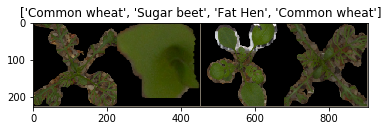

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


# Get a batch of training data
inputs, classes = next(iter(Train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
# training model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
#可视化一些prediction
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()  #设置为evaluation模式
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
#Fine tuning


model_ft = models.resnet18(pretrained=True)   #使用resnet18
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 12)  #保留fc最后一层的in_feature=512,输出为12

# model_ft.load_state_dict(torch.load('params.pkl'))  #加载训练好的模型

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs, learning rate 每7个epoch缩小为0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]


In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
torch.save(model_ft.state_dict(), '/content/drive/My Drive/课程作业/MachineLearning/MLproject/seg_res18_params.pkl')

visualize_model(model_ft, num_images=6)

Epoch 0/24
----------
Train Loss: 1.9868 Acc: 0.3290
Test Loss: 0.9531 Acc: 0.6735

Epoch 1/24
----------
Train Loss: 0.9893 Acc: 0.6735
Test Loss: 0.6931 Acc: 0.7653

Epoch 2/24
----------
Train Loss: 0.5622 Acc: 0.8329
Test Loss: 0.5679 Acc: 0.7551

Epoch 3/24
----------
Train Loss: 0.3661 Acc: 0.8843
Test Loss: 0.5842 Acc: 0.7959

Epoch 4/24
----------
Train Loss: 0.3013 Acc: 0.9229
Test Loss: 0.4537 Acc: 0.8265

Epoch 5/24
----------
Train Loss: 0.1913 Acc: 0.9563
Test Loss: 0.6597 Acc: 0.7755

Epoch 6/24
----------
Train Loss: 0.2099 Acc: 0.9409
Test Loss: 0.3749 Acc: 0.8673

Epoch 7/24
----------
Train Loss: 0.1365 Acc: 0.9717
Test Loss: 0.3548 Acc: 0.8980

Epoch 8/24
----------
Train Loss: 0.1206 Acc: 0.9692
Test Loss: 0.3815 Acc: 0.8980

Epoch 9/24
----------
Train Loss: 0.1028 Acc: 0.9717
Test Loss: 0.3452 Acc: 0.8878

Epoch 10/24
----------
Train Loss: 0.1435 Acc: 0.9537
Test Loss: 0.3621 Acc: 0.9082

Epoch 11/24
----------
Train Loss: 0.1216 Acc: 0.9794
Test Loss: 0.3684 Acc: 0.8673

Epoch 12/24
----------
Train Loss: 0.0844 Acc: 0.9897
Test Loss: 0.4281 Acc: 0.8673

Epoch 13/24
----------
Train Loss: 0.0736 Acc: 0.9923
Test Loss: 0.3789 Acc: 0.8673

Epoch 14/24
----------
Train Loss: 0.0824 Acc: 0.9820
Test Loss: 0.3617 Acc: 0.8878

Epoch 15/24
----------
Train Loss: 0.1066 Acc: 0.9692
Test Loss: 0.3745 Acc: 0.8776

Epoch 16/24
----------
Train Loss: 0.0764 Acc: 0.9871
Test Loss: 0.3544 Acc: 0.9082

Epoch 17/24
----------
Train Loss: 0.0843 Acc: 0.9820
Test Loss: 0.3894 Acc: 0.8571

Epoch 18/24
----------
Train Loss: 0.0741 Acc: 0.9820
Test Loss: 0.3887 Acc: 0.8878

Epoch 19/24
----------
Train Loss: 0.0484 Acc: 0.9974
Test Loss: 0.4200 Acc: 0.8571

Epoch 20/24
----------
Train Loss: 0.1159 Acc: 0.9717
Test Loss: 0.4190 Acc: 0.8878

Epoch 21/24
----------
Train Loss: 0.0872 Acc: 0.9846
Test Loss: 0.3782 Acc: 0.8673

Epoch 22/24
----------
Train Loss: 0.1488 Acc: 0.9589
Test Loss: 0.4201 Acc: 0.8776

Epoch 23/24
----------
Train Loss: 0.0676 Acc: 0.9871
Test Loss: 0.3726 Acc: 0.8673

Epoch 24/24
----------
Train Loss: 0.0680 Acc: 0.9923
Test Loss: 0.4232 Acc: 0.8571

Training complete in 58m 36s
Best val Acc: 0.908163